<a href="https://colab.research.google.com/github/jigimmie/Aiffel_jigimmie/blob/main/credit_fraud_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 신용카드 사기 탐지 분류 문제

이 노트북의 다음 라이브러리 버전은 "파이썬 머신러닝 완벽 가이드 개정2판"을 기준으로 설정되었습니다.

### 라이브러리 버전
2. `xgboost` : 1.5.0
3. `lightgbm` : 3.3.2

### 기타 사용 라이브러리
1. `hyperopt`

In [ ]:
!pip uninstall -y xgboost lightgbm

Found existing installation: xgboost 1.5.0
Uninstalling xgboost-1.5.0:
  Successfully uninstalled xgboost-1.5.0
Found existing installation: lightgbm 3.3.2
Uninstalling lightgbm-3.3.2:
  Successfully uninstalled lightgbm-3.3.2


In [ ]:
!pip install --upgrade xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 MB 4.6 MB/s eta 0:00:00
  Attempting uninstall: xgboost
    Found existing installation: xgboost 1.5.0
    Uninstalling xgboost-1.5.0:
      Successfully uninstalled xgboost-1.5.0


In [ ]:
!pip install lightgbm==3.3.2

In [ ]:
!pip install hyperopt

In [ ]:
from google.colab import drive
drive.mount('/drive')

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# 훈련 데이터와 테스트 데이터는 미리 준비되어 있습니다.

train_df = pd.read_csv('../drive/MyDrive/aiffel_bootcamp/card_fraud/train.csv')
test_df = pd.read_csv('../drive/MyDrive/aiffel_bootcamp/card_fraud/test.csv')

# 데이터셋 정보

2013년 9월 유럽 신용카드 사용자들의 거래 내역을 포함하고 있습니다.
이 데이터셋은 이틀 간의 거래 내역으로 데이터셋은 크게 불균형하며, 사기 거래(양성 클래스)는 전체 거래의 약 0.17%에 불과합니다.

이 데이터셋은 PCA 변환을 거친 수치형 변수들만 포함하고 있습니다. 안타깝게도 기밀 유지 문제로 인해 원본 특징과 데이터에 대한 자세한 배경 정보는 제공할 수 없습니다. V1, V2, …, V28은 PCA로 얻은 주성분이며, PCA 변환을 거치지 않은 유일한 특징은 'Time'과 'Amount'입니다. 'Time'은 각 거래와 데이터셋의 첫 거래 사이의 경과 시간(초)을 나타내며, 'Amount'는 거래 금액입니다. 'Amount' 특징은 예시 의존적 비용 민감 학습 등에 사용될 수 있습니다. 'Class'는 응답 변수로, 사기 거래인 경우 1, 그렇지 않은 경우 0의 값을 가집니다.

클래스 불균형 비율을 고려하여, 정밀도-재현율 곡선 아래 영역(AUPRC)을 사용하여 정확도를 측정할 것을 권장합니다. 불균형 분류에서는 혼동 행렬 정확도가 큰 의미가 없습니다.

이 데이터셋은 Worldline과 ULB(브뤼셀 자유 대학교) 머신러닝 그룹(http://mlg.ulb.ac.be) 간의 빅데이터 마이닝 및 사기 탐지 관련 연구 협력을 통해 수집 및 분석되었습니다.
관련 주제에 대한 현재 및 과거 프로젝트에 대한 자세한 내용은 https://www.researchgate.net/project/Fraud-detection-5 및 DefeatFraud 프로젝트 페이지에서 확인할 수 있습니다.

In [ ]:
train_df

,id,Time,V1,V2,V3,V4,V5,V6,V7,V8,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170878,170878,120394.0,2.085243,0.153914,-1.937797,0.455977,0.457744,-1.599438,0.828357,-0.606184,...,0.146098,0.674611,-0.092485,0.116184,0.578814,-0.074287,-0.049963,-0.071206,13.12,0
170879,170879,120395.0,1.941601,-0.105717,-2.025099,0.021689,1.257679,1.180161,-0.212451,0.406611,...,-0.275532,-0.651069,0.353144,-1.058401,-0.454839,0.282256,-0.022103,-0.058297,1.98,0
170880,170880,120395.0,-0.184060,1.192288,-0.831053,-0.379134,0.898165,-0.494622,0.780753,-0.873814,...,0.755613,-0.315061,0.223707,0.640872,-1.259095,0.179031,0.105884,0.271658,17.60,0
170881,170881,120395.0,1.418125,-1.676690,-0.942455,0.734790,-0.915707,0.286333,-0.420231,0.070484,...,-0.078157,-0.408628,0.023694,0.628874,-0.337955,-0.753715,-0.002207,0.020888,327.60,0


In [ ]:
train_df.describe()

,id,Time,V1,V2,V3,V4,V5,V6,V7,V8,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,...,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000
mean,85441.000000,61091.567090,-0.169838,0.040771,0.493037,0.117429,-0.176102,0.058235,-0.080669,0.032227,...,-0.028287,-0.083744,-0.022450,0.009008,0.092269,0.012603,0.002093,0.002445,87.336704,0.002107
std,49329.817362,27828.109419,1.850529,1.610874,1.383241,1.371910,1.338609,1.295123,1.208518,1.227630,...,0.743713,0.667318,0.584508,0.598760,0.465505,0.490660,0.391951,0.307315,245.954429,0.045851
min,0.000000,0.000000,-56.407510,-72.715728,-33.680984,-5.519697,-42.147898,-26.160506,-43.557242,-73.216718,...,-34.830382,-10.933144,-44.807735,-2.836627,-10.295397,-2.604551,-22.565679,-11.710896,0.000000,0.000000
25%,42720.500000,41216.500000,-0.986667,-0.539174,-0.064747,-0.743475,-0.828769,-0.691129,-0.586314,-0.162638,...,-0.230722,-0.546777,-0.170294,-0.332459,-0.195933,-0.330346,-0.065125,-0.027054,5.480000,0.000000
50%,85441.000000,60776.000000,-0.183560,0.109679,0.623352,0.124307,-0.226228,-0.202634,-0.031932,0.056664,...,-0.054462,-0.066786,-0.036211,0.059474,0.135662,-0.058966,0.008693,0.021152,21.890000,0.000000
75%,128161.500000,78622.000000,1.184446,0.804221,1.297352,0.937632,0.374445,0.449200,0.462616,0.350995,...,0.128337,0.363165,0.098707,0.415860,0.399458,0.272938,0.089727,0.078302,76.720000,0.000000
max,170882.000000,120396.000000,2.439207,22.057729,9.382558,16.875344,34.801666,22.529298,36.677268,20.007208,...,27.202839,10.503090,19.002942,4.022866,7.519589,3.517346,12.152401,33.847808,19656.530000,1.000000


In [ ]:
train_df.info() #id, class 제외하고는 전부 float, 결측치도 없음!

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170883 entries, 0 to 170882
Data columns (total 32 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      170883 non-null  int64  
 1   Time    170883 non-null  float64
 2   V1      170883 non-null  float64
 3   V2      170883 non-null  float64
 4   V3      170883 non-null  float64
 5   V4      170883 non-null  float64
 6   V5      170883 non-null  float64
 7   V6      170883 non-null  float64
 8   V7      170883 non-null  float64
 9   V8      170883 non-null  float64
 10  V9      170883 non-null  float64
 11  V10     170883 non-null  float64
 12  V11     170883 non-null  float64
 13  V12     170883 non-null  float64
 14  V13     170883 non-null  float64
 15  V14     170883 non-null  float64
 16  V15     170883 non-null  float64
 17  V16     170883 non-null  float64
 18  V17     170883 non-null  float64
 19  V18     170883 non-null  float64
 20  V19     170883 non-null  float64
 21  V20     17

In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113923 entries, 0 to 113922
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      113923 non-null  int64  
 1   Time    113923 non-null  float64
 2   V1      113923 non-null  float64
 3   V2      113923 non-null  float64
 4   V3      113923 non-null  float64
 5   V4      113923 non-null  float64
 6   V5      113923 non-null  float64
 7   V6      113923 non-null  float64
 8   V7      113923 non-null  float64
 9   V8      113923 non-null  float64
 10  V9      113923 non-null  float64
 11  V10     113923 non-null  float64
 12  V11     113923 non-null  float64
 13  V12     113923 non-null  float64
 14  V13     113923 non-null  float64
 15  V14     113923 non-null  float64
 16  V15     113923 non-null  float64
 17  V16     113923 non-null  float64
 18  V17     113923 non-null  float64
 19  V18     113923 non-null  float64
 20  V19     113923 non-null  float64
 21  V20     11

<Axes: xlabel='Class', ylabel='Count'>

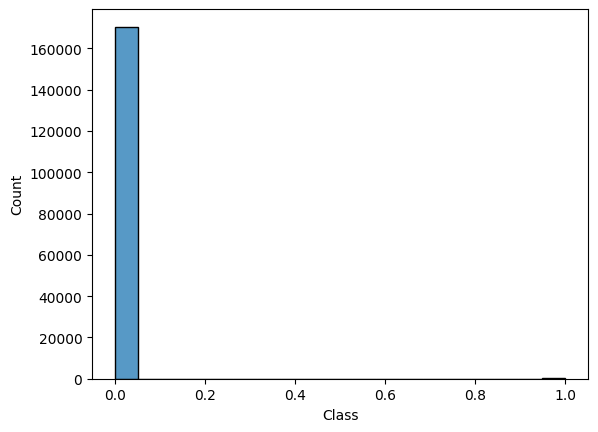

In [ ]:
sns.histplot(x = train_df['Class']) #타겟 피처의 분포가 굉장히 불균형 함을 확인할 수 있다.

In [ ]:
train_df.groupby('Class')['id'].count() #사기 데이터는 360개에 불과함.

,id
Class,
0,170523
1,360


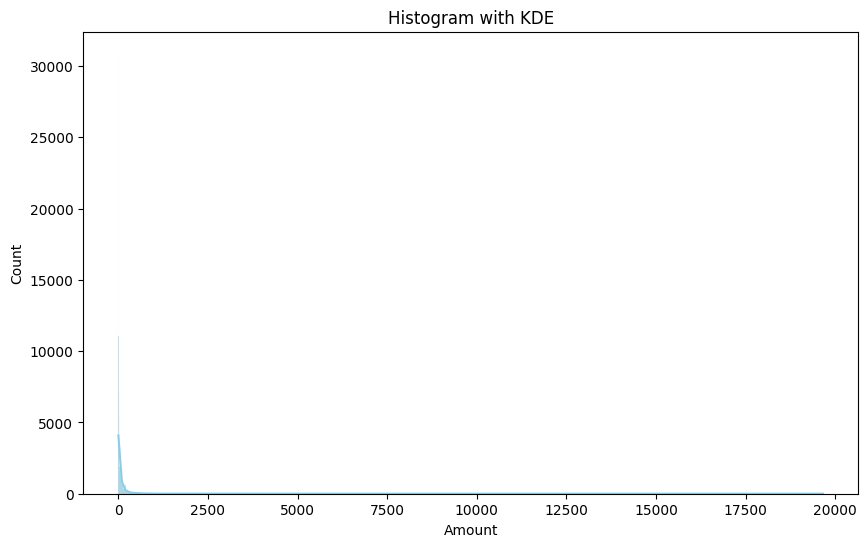

In [ ]:
# Amount 피처를 살펴보기 - 오른쪽으로 꼬리가 굉장히 긴 극단적인 값임을 확인할 수 있음. 따라서 로그변환을 해줘야 할 필요성.
plt.figure(figsize=(10, 6))
sns.histplot(train_df['Amount'], kde=True, color='skyblue')
plt.title('Histogram with KDE')
plt.show()

In [ ]:
#amount 로그 변환.
train_df['Amount'] = np.log1p(train_df['Amount'])

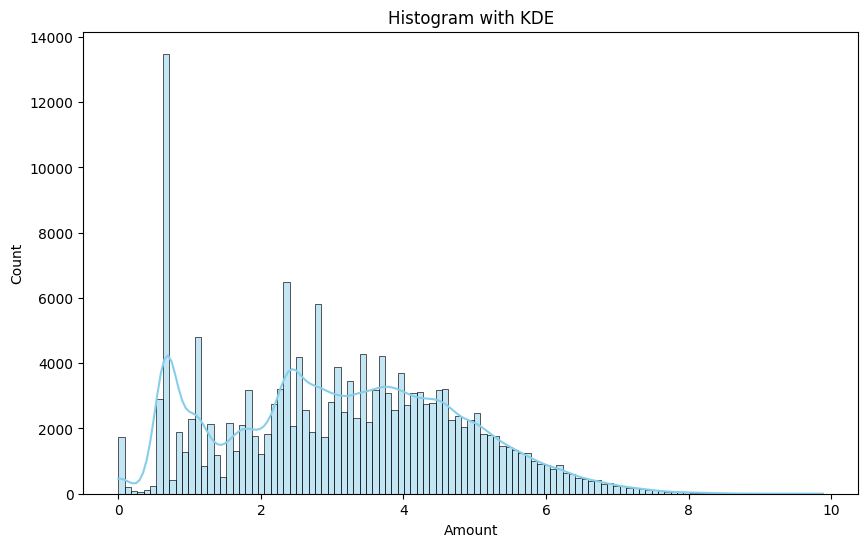

In [ ]:
# 로그변환된 amount값 확인. 트리 기반 알고리즘들을 쓸 예정이라서 따로 스케일링은 진행하지 않음.(로지스틱에서는 스케일링 해줌)
plt.figure(figsize=(10, 6))
sns.histplot(train_df['Amount'], kde=True, color='skyblue')
plt.title('Histogram with KDE')
plt.show()

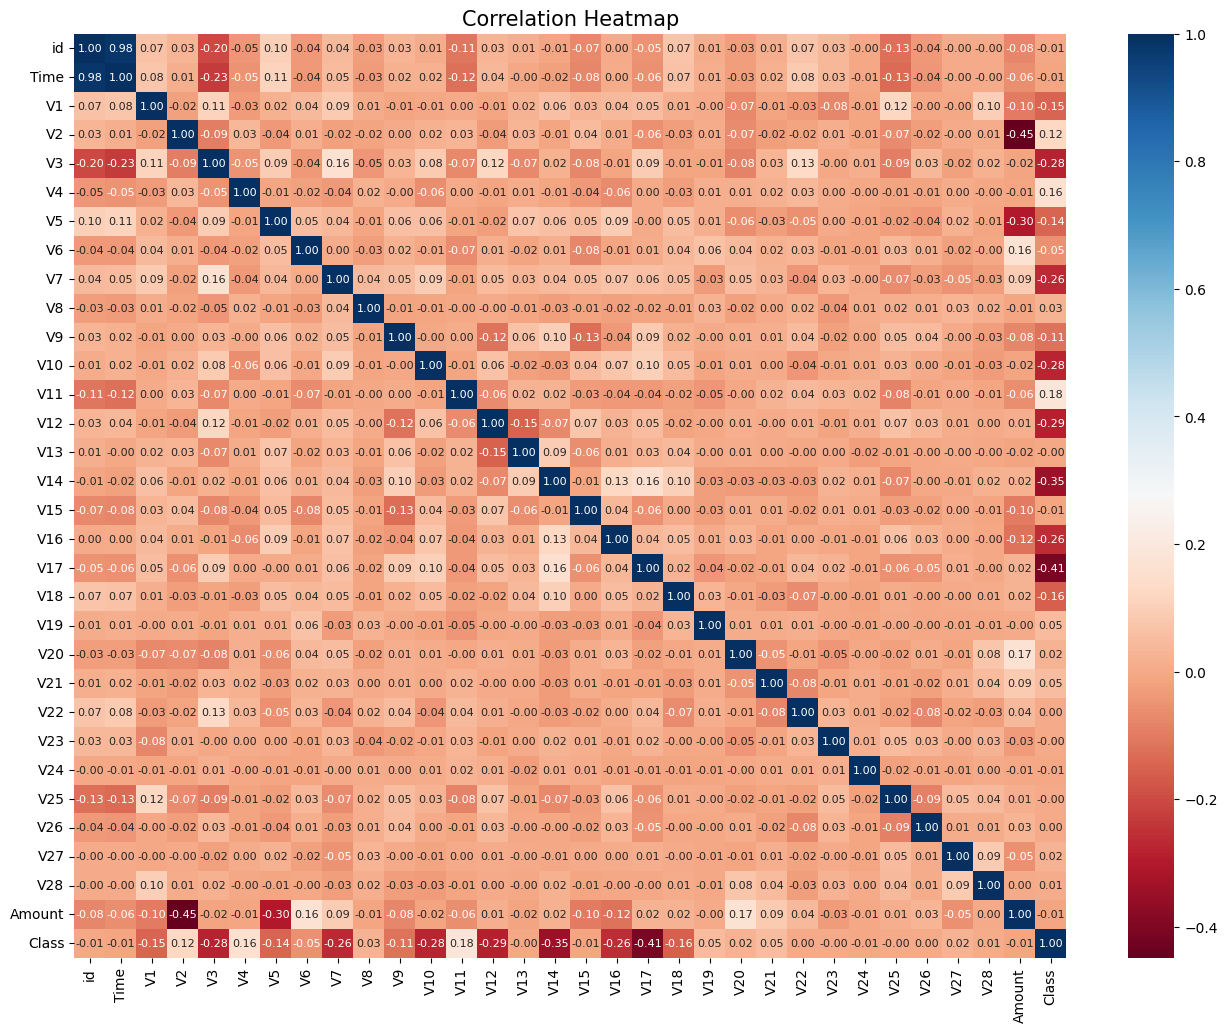

In [ ]:
plt.figure(figsize=(16, 12))

corr = train_df.corr()

sns.heatmap(corr, annot=True, fmt='.2f', cmap='RdBu', annot_kws={'size': 8})

plt.title('Correlation Heatmap', fontsize=15)
plt.show()

#V17, V14 변수가 상관관계가 높은 편임을 확인할 수 있었음. (아주 높은 편은 아니지만 다른 변수보다)
#time의 경우 모두 모델링에 사용하지 않을 예정이라서 따로 처리하지 않음.

/tmp/ipython-input-1520342666.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(train_df[train_df['Class'] == 0]['V14'], label='Normal', shade=True)
/tmp/ipython-input-1520342666.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(train_df[train_df['Class'] == 1]['V14'], label='Fraud', shade=True)
/tmp/ipython-input-1520342666.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(train_df[train_df['Class'] == 0]['V17'], label='Normal', shade=True)
/tmp/ipython-input-1520342666.py:11: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please u

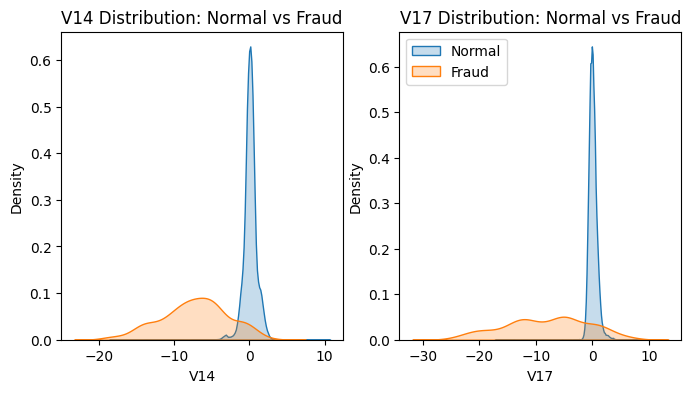

In [ ]:
# V14, V17 피처에 대해 정상과 사기의 분포 비교
plt.figure(figsize=(8, 4))
plt.subplot(1,2,1)
sns.kdeplot(train_df[train_df['Class'] == 0]['V14'], label='Normal', shade=True)
sns.kdeplot(train_df[train_df['Class'] == 1]['V14'], label='Fraud', shade=True)
plt.title('V14 Distribution: Normal vs Fraud')


plt.subplot(1,2,2)
sns.kdeplot(train_df[train_df['Class'] == 0]['V17'], label='Normal', shade=True)
sns.kdeplot(train_df[train_df['Class'] == 1]['V17'], label='Fraud', shade=True)
plt.title('V17 Distribution: Normal vs Fraud')
plt.legend()
plt.show()

두 변수 다 fraud와 normal이 완전 떨어져있지는 않지만, 그래도 분포로 확인했을때 어느정도 다른 모양의 분포를 가지고 있음을 확인할 수 있음(중심과 분산이 다름). 따라서 꽤 타겟 피처를 결정하는데 꽤 중요한 역할을 할 것으로 보임.

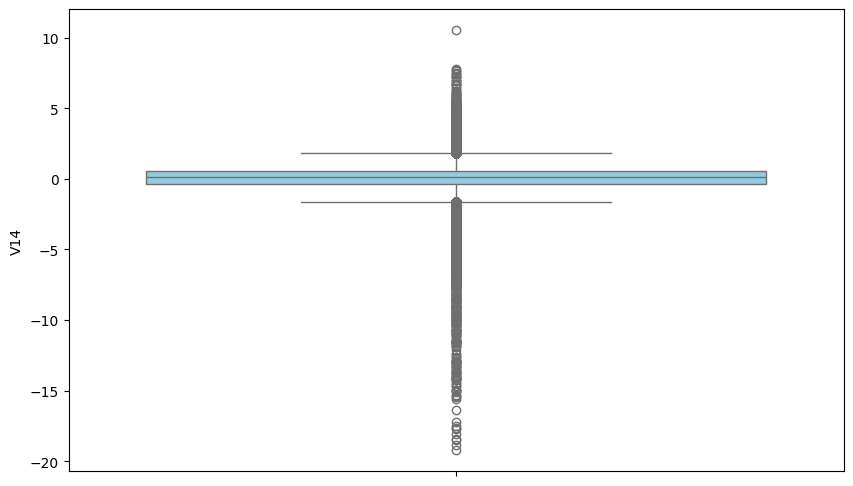

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(train_df['V14'], color='skyblue')
plt.show()

<Axes: xlabel='V14', ylabel='Count'>

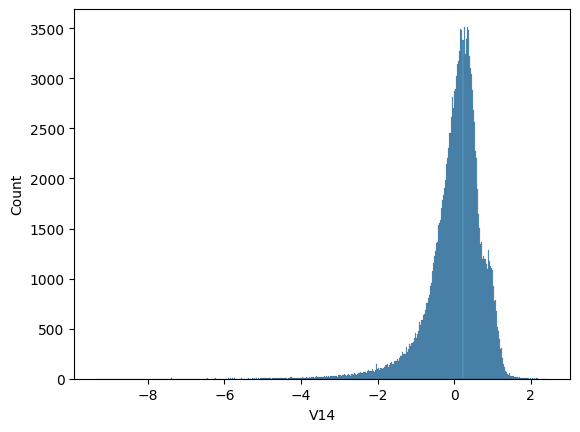

In [ ]:
sns.histplot(train_df['V14'])

In [ ]:
train_df['V14'].sort_values()

,V14
8296,-19.214325
8615,-18.822087
9035,-18.493773
118764,-18.392091
9252,-18.049998
...,...
138706,7.518403
77672,7.667726
12533,7.692209
139217,7.754599


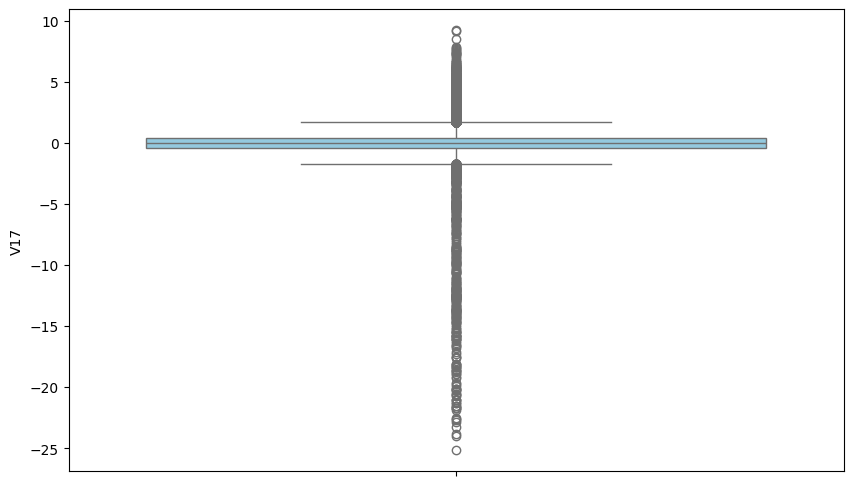

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(train_df['V17'], color='skyblue')
plt.show()

<Axes: xlabel='V17', ylabel='Count'>

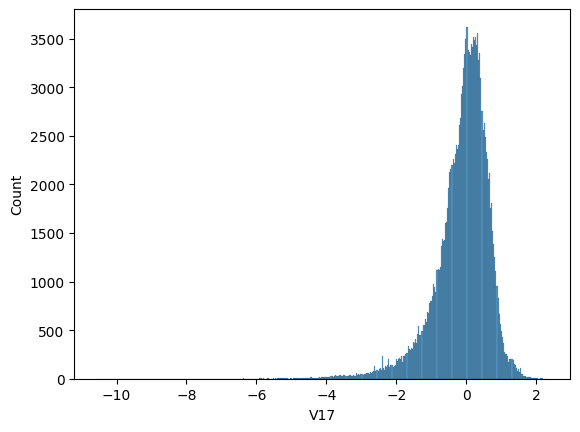

In [ ]:
sns.histplot(train_df['V17'])

둘다 사기 데이터의 영향으로 음수쪽이 꼬리가 긴 것을 확인할 수 있음. 따라서 로지스틱 회귀를 할때 scaler를 사용하기로 하겠슴.

# 뼈대 만들기

머신러닝 파이프라인은

데이터 준비 → 모델 정의 → 학습 → 예측 → 평가의 형태를 띕니다.

최소한의 형태로 파이프라인만 구성해 보겠습니다.

**1. 로지스틱 회귀**

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import LogisticRegression
import numpy as np
import pandas as pd

# 1. 데이터 전처리
train_copy = train_df.copy()

# 불필요한 컬럼 제거
train_copy.drop(['Time', 'id'], axis=1, inplace=True)

# Amount -> StandardScaler 적용
scaler = StandardScaler()
train_copy['Amount'] = scaler.fit_transform(train_copy[['Amount']])

# V14, V17 -> RobustScaler 적용
robust = RobustScaler()
train_copy[['V14', 'V17']] = robust.fit_transform(train_copy[['V14', 'V17']])

# 2. X(피처)와 y(타겟) 분리

X_features = train_copy.drop(['Class'], axis=1)
y_target = train_copy['Class']

# 3. 3-Fold Stratified K-Fold 교차 검증

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
f1_list = []

# 모델 정의
lr_clf = LogisticRegression(max_iter=1000, random_state=42)

print(f"전처리 완료! 데이터셋 크기: {X_features.shape}")
print("3-Fold 교차 검증 시작...\n")

for iter_count, (train_index, val_index) in enumerate(skf.split(X_features, y_target)):
    # 데이터 분할
    X_train_fold = X_features.iloc[train_index]
    X_val_fold = X_features.iloc[val_index]
    y_train_fold = y_target.iloc[train_index]
    y_val_fold = y_target.iloc[val_index]

    # 모델 학습
    lr_clf.fit(X_train_fold, y_train_fold)

    # 예측
    preds = lr_clf.predict(X_val_fold)

    # 평가 (F1 Score)
    f1 = f1_score(y_val_fold, preds)
    f1_list.append(f1)

    print(f"## 폴드 {iter_count+1} F1 Score: {f1:.4f}")
    print(f"혼동 행렬 (TN, FP / FN, TP):\n{confusion_matrix(y_val_fold, preds)}")
    print("-" * 30)

print(f"\n최종 평균 F1 Score: {np.mean(f1_list):.4f}")

전처리 완료! 데이터셋 크기: (170883, 29)
3-Fold 교차 검증 시작...

## 폴드 1 F1 Score: 0.7075
혼동 행렬 (TN, FP / FN, TP):
[[56824    17]
 [   45    75]]
------------------------------
## 폴드 2 F1 Score: 0.6866
혼동 행렬 (TN, FP / FN, TP):
[[56829    12]
 [   51    69]]
------------------------------
## 폴드 3 F1 Score: 0.7075
혼동 행렬 (TN, FP / FN, TP):
[[56824    17]
 [   45    75]]
------------------------------

최종 평균 F1 Score: 0.7006


In [ ]:
print('학습 데이터 간 레이블 값 비율')
print(y_train_fold.value_counts()/y_train_fold.shape[0] * 100)
print('검증 데이터 간 레이블 값 비율')
print(y_val_fold.value_counts()/y_val_fold.shape[0] * 100)

학습 데이터 간 레이블 값 비율
Class
0    99.78933
1     0.21067
Name: count, dtype: float64
검증 데이터 간 레이블 값 비율
Class
0    99.78933
1     0.21067
Name: count, dtype: float64


**로지스틱 회귀 f-1: 70%**



**2.xgboost**

In [ ]:
train_copy = train_df.copy()
#time,id는 삭제함.
train_copy.drop(['Time', 'id'], axis=1, inplace=True)

X_features = train_copy.iloc[:, :-1]
y_target = train_copy.iloc[:, -1]
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_features, y_target, test_size=0.2, random_state=42, stratify=y_target)



In [ ]:
print('학습 데이터 간 레이블 값 비율')
print(y_train.value_counts()/y_train.shape[0] * 100)
print('검증 데이터 간 레이블 값 비율')
print(y_val.value_counts()/y_val.shape[0] * 100)

학습 데이터 간 레이블 값 비율
Class
0    99.789329
1     0.210671
Name: count, dtype: float64
검증 데이터 간 레이블 값 비율
Class
0    99.789332
1     0.210668
Name: count, dtype: float64


==================== XGBoost 3-Fold 교차 검증 시작 ====================
[Fold 1]
혼동 행렬:
[[56834     7]
 [   20   100]]
정밀도: 0.9346, 재현율: 0.8333, F1: 0.8811, AUC: 0.9746
--------------------------------------------------
[Fold 2]
혼동 행렬:
[[56836     5]
 [   21    99]]
정밀도: 0.9519, 재현율: 0.8250, F1: 0.8839, AUC: 0.9785
--------------------------------------------------
[Fold 3]
혼동 행렬:
[[56833     8]
 [   21    99]]
정밀도: 0.9252, 재현율: 0.8250, F1: 0.8722, AUC: 0.9774
--------------------------------------------------

 [최종 평균 결과]
평균 정확도 : 0.9995
평균 정밀도 : 0.9372
평균 재현율 : 0.8278
평균 F1 점수: 0.8791
평균 AUC    : 0.9768

📊 Feature Importance (마지막 Fold 기준)


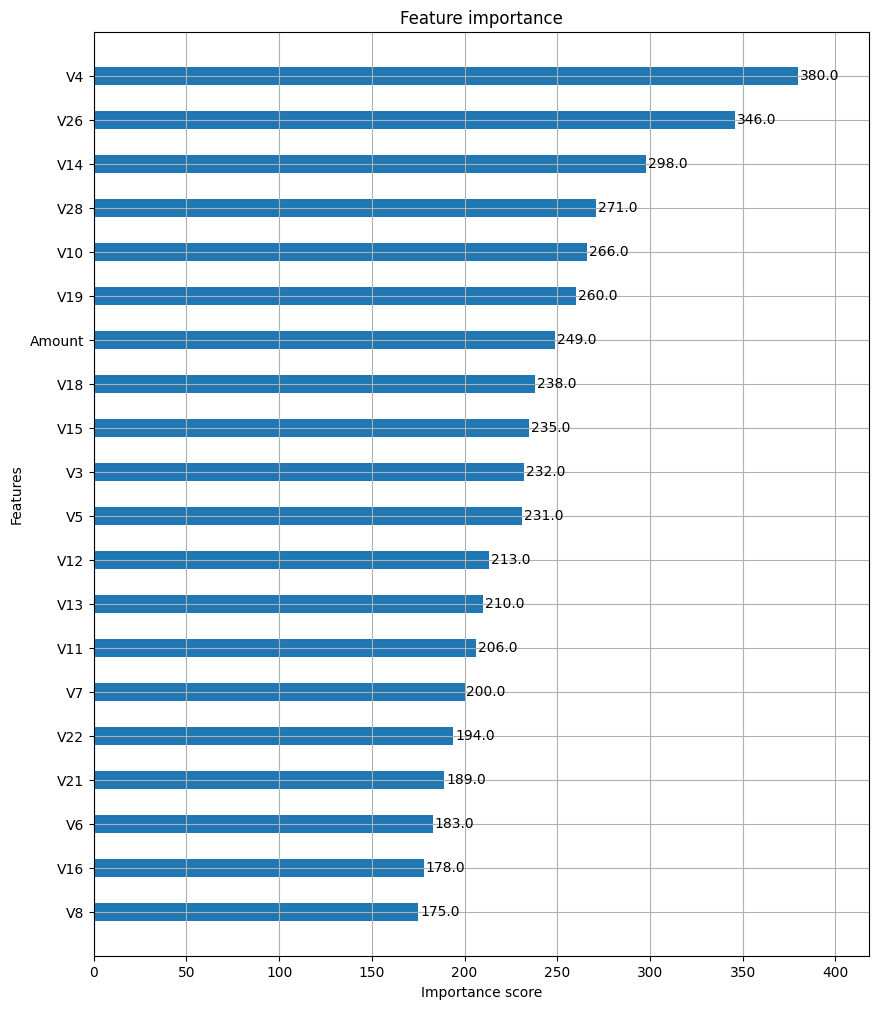

In [ ]:
from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd



# 1. 3-Fold 설정
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# 점수 저장을 위한 리스트
metrics = {
    'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'auc': []
}

print("="*20 + " XGBoost 3-Fold 교차 검증 시작 " + "="*20)

for iter_count, (train_index, val_index) in enumerate(skf.split(X_features, y_target)):
    # 데이터 분할
    X_train_fold = X_features.iloc[train_index]
    X_val_fold = X_features.iloc[val_index]
    y_train_fold = y_target.iloc[train_index]
    y_val_fold = y_target.iloc[val_index]

    # 2. 모델 생성

    xgb_clf = XGBClassifier(
        n_estimators=1000,      # 반복 횟수
        learning_rate=0.05,     # 학습률
        max_depth=6,            # 트리 깊이
        random_state=42,
        n_jobs=-1,              # 모든 CPU 코어 사용
        tree_method='hist',     # 학습 속도 향상
        eval_metric='aucpr',
        early_stopping_rounds=50 # 조기 중단 설정
    )

    # 3. 학습
    xgb_clf.fit(
        X_train_fold, y_train_fold,
        eval_set=[(X_val_fold, y_val_fold)],
        verbose=False
    )

    # 4. 예측 및 평가
    y_pred = xgb_clf.predict(X_val_fold)
    y_pred_proba = xgb_clf.predict_proba(X_val_fold)[:, 1]

    # 지표 계산
    acc = accuracy_score(y_val_fold, y_pred)
    prec = precision_score(y_val_fold, y_pred, zero_division=0)
    rec = recall_score(y_val_fold, y_pred, zero_division=0)
    f1 = f1_score(y_val_fold, y_pred, zero_division=0)
    auc = roc_auc_score(y_val_fold, y_pred_proba)

    # 리스트에 저장
    metrics['accuracy'].append(acc)
    metrics['precision'].append(prec)
    metrics['recall'].append(rec)
    metrics['f1'].append(f1)
    metrics['auc'].append(auc)

    print(f"[Fold {iter_count+1}]")
    print(f"혼동 행렬:\n{confusion_matrix(y_val_fold, y_pred)}")
    print(f"정밀도: {prec:.4f}, 재현율: {rec:.4f}, F1: {f1:.4f}, AUC: {auc:.4f}")
    print("-" * 50)

# 5. 최종 평균 결과 출력
print(f"\n [최종 평균 결과]")
print(f"평균 정확도 : {np.mean(metrics['accuracy']):.4f}")
print(f"평균 정밀도 : {np.mean(metrics['precision']):.4f}")
print(f"평균 재현율 : {np.mean(metrics['recall']):.4f}")
print(f"평균 F1 점수: {np.mean(metrics['f1']):.4f}")
print(f"평균 AUC    : {np.mean(metrics['auc']):.4f}")

# 6. Feature Importance 시각화 (마지막 Fold 모델 기준)
print("\n Feature Importance (마지막 Fold 기준)")
fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(xgb_clf, ax=ax, max_num_features=20, height=0.4)
plt.show()

/tmp/ipython-input-3522481859.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(train_df[train_df['Class'] == 0]['V4'], label='Normal', shade=True)
/tmp/ipython-input-3522481859.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(train_df[train_df['Class'] == 1]['V4'], label='Fraud', shade=True)


Text(0.5, 1.0, 'V4 Distribution: Normal vs Fraud')

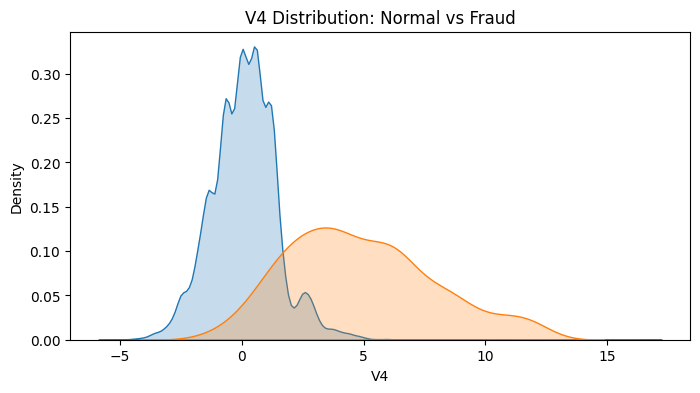

In [ ]:
plt.figure(figsize=(8, 4))
sns.kdeplot(train_df[train_df['Class'] == 0]['V4'], label='Normal', shade=True)
sns.kdeplot(train_df[train_df['Class'] == 1]['V4'], label='Fraud', shade=True)
plt.title('V4 Distribution: Normal vs Fraud')

**xgboost: f-1 score 87%**

**3. lightgbm**

In [ ]:
train_copy = train_df.copy()
#time,id는 삭제함.
train_copy.drop(['Time', 'id'], axis=1, inplace=True)

X_features = train_copy.iloc[:, :-1]
y_target = train_copy.iloc[:, -1]
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_features, y_target, test_size=0.2, random_state=42, stratify=y_target)


In [ ]:
print('학습 데이터 간 레이블 값 비율')
print(y_train.value_counts()/y_train.shape[0] * 100)
print('검증 데이터 간 레이블 값 비율')
print(y_val.value_counts()/y_val.shape[0] * 100)

학습 데이터 간 레이블 값 비율
Class
0    99.789329
1     0.210671
Name: count, dtype: float64
검증 데이터 간 레이블 값 비율
Class
0    99.789332
1     0.210668
Name: count, dtype: float64



==================== 3-Fold LightGBM ====================


/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 1
  F1 Score: 0.8417
 정밀도: 0.8417, 재현율: 0.8417
 혼동 행렬:
[[56822    19]
 [   19   101]]
--------------------------------------------------


/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 2
  F1 Score: 0.8596
 정밀도: 0.9074, 재현율: 0.8167
 혼동 행렬:
[[56831    10]
 [   22    98]]
--------------------------------------------------


/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 3
  F1 Score: 0.8246
 정밀도: 0.8704, 재현율: 0.7833
 혼동 행렬:
[[56827    14]
 [   26    94]]
--------------------------------------------------

최종 평균 F1 Score: 0.8420


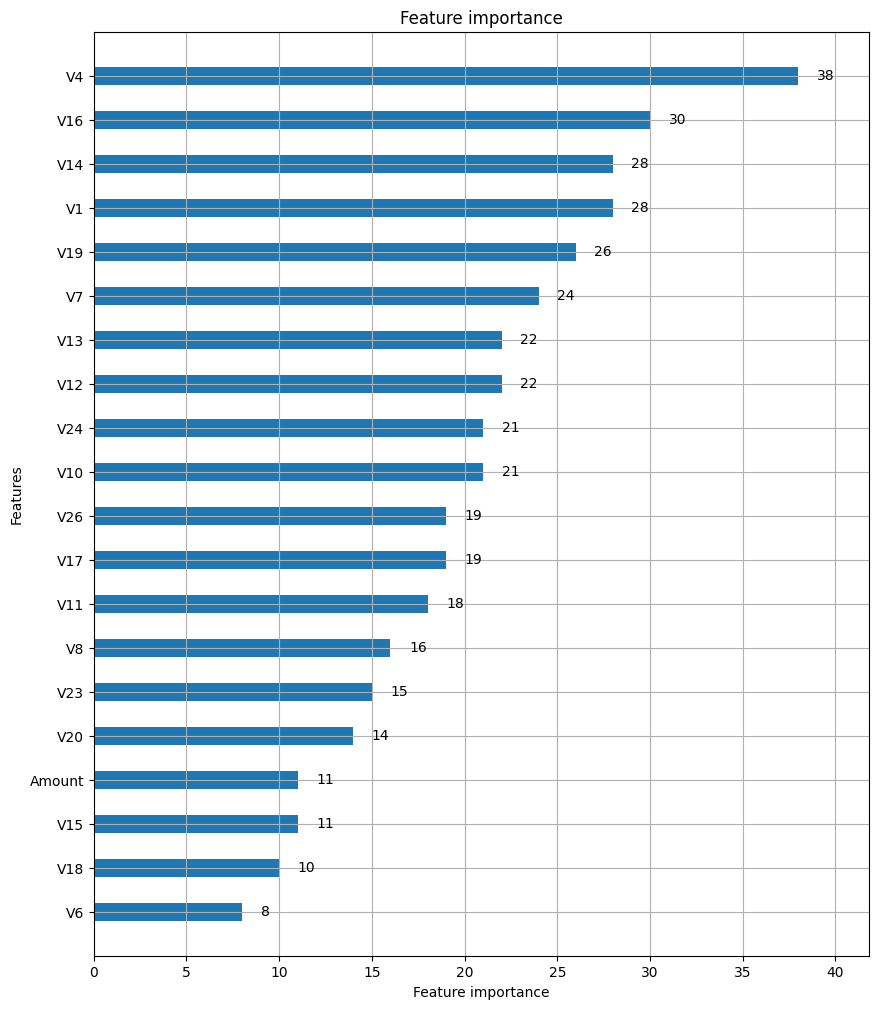

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from lightgbm import LGBMClassifier
import numpy as np
from lightgbm import plot_importance

# 3-Fold 설정
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
f1_list = []

print("\n" + "="*20 + " 3-Fold LightGBM " + "="*20)

for iter_count, (train_index, val_index) in enumerate(skf.split(X_features, y_target)):
    # 1. 데이터 분할
    X_train_fold = X_features.iloc[train_index]
    X_val_fold = X_features.iloc[val_index]
    y_train_fold = y_target.iloc[train_index]
    y_val_fold = y_target.iloc[val_index]

    # 2. 모델 생성
    lgbm_fold = LGBMClassifier(
        n_estimators=1000,
        num_leaves=64,
        learning_rate=0.05,
        random_state=42,
        n_jobs=-1,
        boost_from_average=False
    )

    # 3. 학습
    lgbm_fold.fit(
        X_train_fold, y_train_fold,
        eval_set=[(X_val_fold, y_val_fold)],
        eval_metric="auc",
        early_stopping_rounds=50,
        verbose=False
    )

    # 4. 예측
    pred = lgbm_fold.predict(X_val_fold)

    # 5. 평가
    f1 = f1_score(y_val_fold, pred)
    f1_list.append(f1)

    # 결과 출력
    print(f"Fold {iter_count+1}")
    print(f"  F1 Score: {f1:.4f}")
    print(f" 정밀도: {precision_score(y_val_fold, pred):.4f}, 재현율: {recall_score(y_val_fold, pred):.4f}")
    print(f" 혼동 행렬:\n{confusion_matrix(y_val_fold, pred)}")
    print("-" * 50)

print(f"\n최종 평균 F1 Score: {np.mean(f1_list):.4f}")

fig, ax = plt.subplots(figsize=(10, 12))
# max_num_features=20 : 상위 20개만 표시
plot_importance(lgbm_fold, ax=ax, max_num_features=20, height=0.4)
plt.show()

**lightgbm f-1 score:0.84**

xgboost, lightgbm 성능이 제일 좋음으로 이 두 모델에 집중하겠음.

**4. 하이퍼파라미터 튜닝**

In [ ]:
train_copy = train_df.copy()
#time,id는 삭제함.
train_copy.drop(['Time', 'id'], axis=1, inplace=True)

X_features = train_copy.iloc[:, :-1]
y_target = train_copy.iloc[:, -1]
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_features, y_target, test_size=0.2, random_state=42, stratify=y_target)

In [ ]:
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from sklearn.model_selection import cross_val_score, StratifiedKFold
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd



# 학습 데이터 불균형 비율 계산 (scale_pos_weight용) - y_train 기준
ratio = float(y_train.value_counts()[0] / y_train.value_counts()[1])

# [Step 1] Hyperopt 목적 함수 정의

def objective_func(search_space):
    # 1. 모델 설정
    xgb_clf = XGBClassifier(
        n_estimators=int(search_space['n_estimators']),
        max_depth=int(search_space['max_depth']),
        learning_rate=search_space['learning_rate'],
        min_child_weight=int(search_space['min_child_weight']),
        colsample_bytree=search_space['colsample_bytree'],
        subsample=search_space['subsample'],

        # 고정 파라미터
        scale_pos_weight=ratio,
        random_state=42,
        n_jobs=-1,
        tree_method='hist',
        eval_metric='aucpr',
        verbosity=0
    )

    # 2. 교차 검증 (X_train 내부에서 다시 3등분하여 검증)
    acc = cross_val_score(xgb_clf, X_train, y_train, scoring='f1', cv=3)

    # F1 점수 최대화 = (-1 * F1) 최소화
    return {'loss': -1 * np.mean(acc), 'status': STATUS_OK}



# [Step 2] 탐색 공간 설정 및 최적화 실행

search_space = {
    'n_estimators': hp.quniform('n_estimators', 500, 1500, 100),
    'max_depth': hp.quniform('max_depth', 5, 12, 1),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.1),
    'min_child_weight': hp.quniform('min_child_weight', 1, 6, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'subsample': hp.uniform('subsample', 0.5, 1.0)
}

print("Hyperopt 튜닝 시작... (max_evals=20)")
trials = Trials()
best = fmin(
    fn=objective_func,
    space=search_space,
    algo=tpe.suggest,
    max_evals=20,
    trials=trials,
    rstate=np.random.default_rng(42)
)

print(f"\nHyperopt가 찾은 원본 파라미터:\n{best}")



# [Step 3] 최적 파라미터 적용 후 3-Fold 상세 검증

print("\n" + "="*20 + " 최적 파라미터 적용 XGBoost 3-Fold (X_train) " + "="*20)

# 정수형 변환
best['n_estimators'] = int(best['n_estimators'])
best['max_depth'] = int(best['max_depth'])
best['min_child_weight'] = int(best['min_child_weight'])

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
metrics = {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'auc': []}


for iter_count, (train_index, val_index) in enumerate(skf.split(X_train, y_train)):
    # 데이터 분할 (X_train을 다시 쪼개서 학습/검증)
    X_train_fold = X_train.iloc[train_index]
    X_val_fold = X_train.iloc[val_index]
    y_train_fold = y_train.iloc[train_index]
    y_val_fold = y_train.iloc[val_index]

    # 폴드별 불균형 비율 재계산
    fold_ratio = float(y_train_fold.value_counts()[0] / y_train_fold.value_counts()[1])

    # 모델 생성
    xgb_clf = XGBClassifier(
        **best,  # 최적 파라미터
        scale_pos_weight=fold_ratio,
        random_state=42,
        n_jobs=-1,
        tree_method='hist',
        eval_metric='aucpr',
        early_stopping_rounds=50
    )

    # 학습
    xgb_clf.fit(
        X_train_fold, y_train_fold,
        eval_set=[(X_val_fold, y_val_fold)],
        verbose=False
    )

    # 예측
    y_pred = xgb_clf.predict(X_val_fold)
    y_pred_proba = xgb_clf.predict_proba(X_val_fold)[:, 1]

    # 지표 저장
    acc = accuracy_score(y_val_fold, y_pred)
    prec = precision_score(y_val_fold, y_pred, zero_division=0)
    rec = recall_score(y_val_fold, y_pred, zero_division=0)
    f1 = f1_score(y_val_fold, y_pred, zero_division=0)
    auc = roc_auc_score(y_val_fold, y_pred_proba)

    metrics['accuracy'].append(acc)
    metrics['precision'].append(prec)
    metrics['recall'].append(rec)
    metrics['f1'].append(f1)
    metrics['auc'].append(auc)

    print(f"✅ [Fold {iter_count+1}]")
    print(f"혼동 행렬:\n{confusion_matrix(y_val_fold, y_pred)}")
    print(f"정밀도: {prec:.4f}, 재현율: {rec:.4f}, F1: {f1:.4f}, AUC: {auc:.4f}")
    print("-" * 50)

# 최종 평균 결과
print(f"\n🏆 [최종 평균 결과 (Hyperopt Tuned)]")
print(f"평균 정확도 : {np.mean(metrics['accuracy']):.4f}")
print(f"평균 정밀도 : {np.mean(metrics['precision']):.4f}")
print(f"평균 재현율 : {np.mean(metrics['recall']):.4f}")
print(f"평균 F1 점수: {np.mean(metrics['f1']):.4f}")
print(f"평균 AUC    : {np.mean(metrics['auc']):.4f}")

🔍 Hyperopt 튜닝 시작... (max_evals=20)
100%|██████████| 20/20 [17:30<00:00, 52.51s/trial, best loss: -0.8780722491808718]

🏆 Hyperopt가 찾은 원본 파라미터:
{'colsample_bytree': np.float64(0.5527810491040572), 'learning_rate': np.float64(0.08715303601455825), 'max_depth': np.float64(7.0), 'min_child_weight': np.float64(2.0), 'n_estimators': np.float64(1500.0), 'subsample': np.float64(0.9376238045745737)}

==================== 최적 파라미터 적용 XGBoost 3-Fold (X_train) ====================
✅ [Fold 1]
혼동 행렬:
[[45465     8]
 [   11    85]]
정밀도: 0.9140, 재현율: 0.8854, F1: 0.8995, AUC: 0.9812
--------------------------------------------------
✅ [Fold 2]
혼동 행렬:
[[45467     6]
 [   14    82]]
정밀도: 0.9318, 재현율: 0.8542, F1: 0.8913, AUC: 0.9862
--------------------------------------------------
✅ [Fold 3]
혼동 행렬:
[[45462    10]
 [   16    80]]
정밀도: 0.8889, 재현율: 0.8333, F1: 0.8602, AUC: 0.9805
--------------------------------------------------

🏆 [최종 평균 결과 (Hyperopt Tuned)]
평균 정확도 : 0.9995
평균 정밀도 : 0.9116
평균 재현율 : 0.857

하이퍼파라미터 튜닝 후 xgboost f-1 score: 88%

In [ ]:
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from sklearn.model_selection import cross_val_score
from lightgbm import LGBMClassifier
import numpy as np
import pandas as pd


# 1. 학습 데이터 불균형 비율 계산 (scale_pos_weight용)

ratio = float(y_train.value_counts()[0] / y_train.value_counts()[1])


# 2. 목적 함수 정의 (Hyperopt가 최소화할 대상)
def objective_func(search_space):
    lgbm_clf = LGBMClassifier(
        n_estimators=int(search_space['n_estimators']),
        num_leaves=int(search_space['num_leaves']),
        max_depth=int(search_space['max_depth']),
        learning_rate=search_space['learning_rate'],
        min_child_samples=int(search_space['min_child_samples']),
        subsample=search_space['subsample'],
        colsample_bytree=search_space['colsample_bytree'],

        # 고정 파라미터
        scale_pos_weight=ratio,
        boost_from_average=False,
        random_state=42,
        n_jobs=-1,
        verbose=-1
    )

    # 교차 검증 (속도를 위해 early_stopping 없이 진행)
    # F1 Score를 최적화 목표로 설정
    f1_scores = cross_val_score(lgbm_clf, X_train, y_train, scoring='f1', cv=3)

    # Hyperopt는 Loss(최소화)를 원하므로 -1을 곱함
    return {'loss': -1 * np.mean(f1_scores), 'status': STATUS_OK}


# 3. 탐색 공간 설정 및 실행

search_space = {
    'n_estimators': hp.quniform('n_estimators', 500, 1500, 100),
    'num_leaves': hp.quniform('num_leaves', 32, 128, 4),
    'max_depth': hp.quniform('max_depth', 5, 15, 1),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.1),
    'min_child_samples': hp.quniform('min_child_samples', 10, 100, 10),
    'subsample': hp.uniform('subsample', 0.6, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0)
}

print("Hyperopt 튜닝 시작... (max_evals=20)")
trials = Trials()
best_light = fmin(
    fn=objective_func,
    space=search_space,
    algo=tpe.suggest,
    max_evals=20,
    trials=trials,
    rstate=np.random.default_rng(42)
)

print(f"\n 찾은 최적 파라미터:\n{best}")

Hyperopt 튜닝 시작... (max_evals=20)
100%|██████████| 20/20 [20:55<00:00, 62.75s/trial, best loss: -0.8830697181009373]

 찾은 최적 파라미터:
{'colsample_bytree': np.float64(0.5527810491040572), 'learning_rate': np.float64(0.08715303601455825), 'max_depth': 7, 'min_child_weight': 2, 'n_estimators': 1500, 'subsample': np.float64(0.9376238045745737)}



==================== 최적 파라미터 적용 LightGBM 3-Fold ====================


/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[Fold 1]
  혼동 행렬:
[[45315   158]
 [   11    85]]
  F1: 0.5015, 정밀도: 0.3498, 재현율: 0.8854, AUC: 0.9593
--------------------------------------------------


/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[Fold 2]
  혼동 행렬:
[[45459    14]
 [   16    80]]
  F1: 0.8421, 정밀도: 0.8511, 재현율: 0.8333, AUC: 0.9689
--------------------------------------------------


/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[Fold 3]
  혼동 행렬:
[[45442    30]
 [   18    78]]
  F1: 0.7647, 정밀도: 0.7222, 재현율: 0.8125, AUC: 0.9695
--------------------------------------------------

 [최종 평균 결과]
평균 F1 Score: 0.7028
평균 AUC     : 0.9659

 Feature Importance


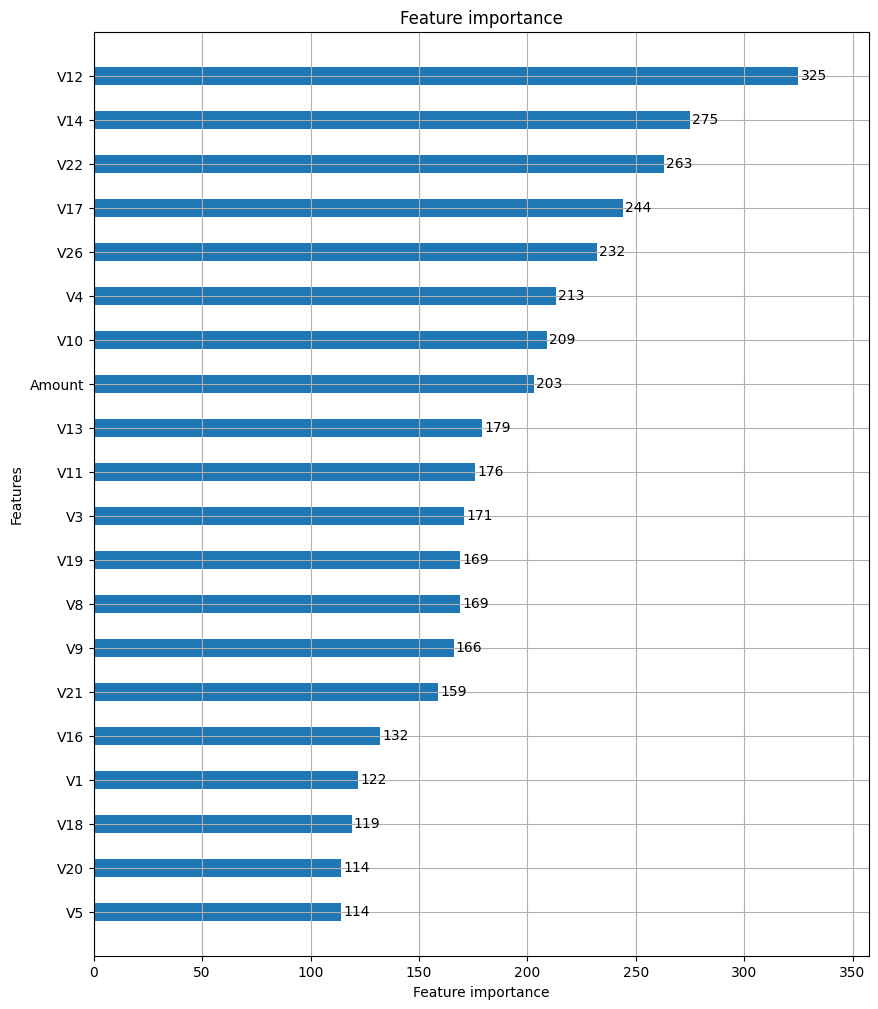

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from lightgbm import LGBMClassifier, plot_importance
import matplotlib.pyplot as plt
import numpy as np

print("\n" + "="*20 + " 최적 파라미터 적용 LightGBM 3-Fold " + "="*20)

# 1. 정수형 파라미터 변환 (Hyperopt 결과는 float이므로 int 변환 필수)
best_light['n_estimators'] = int(best_light['n_estimators'])
best_light['num_leaves'] = int(best_light['num_leaves'])
best_light['max_depth'] = int(best_light['max_depth'])
best_light['min_child_samples'] = int(best_light['min_child_samples'])

# 2. 3-Fold 설정
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
metrics = {'f1': [], 'precision': [], 'recall': [], 'auc': []}

for iter_count, (train_index, val_index) in enumerate(skf.split(X_train, y_train)):
    # 데이터 분할
    X_train_fold = X_train.iloc[train_index]
    X_val_fold = X_train.iloc[val_index]
    y_train_fold = y_train.iloc[train_index]
    y_val_fold = y_train.iloc[val_index]

    # 해당 Fold의 불균형 비율 재계산 (정교한 학습용)
    fold_ratio = float(y_train_fold.value_counts()[0] / y_train_fold.value_counts()[1])

    # 모델 생성 (최적 파라미터 **best_light 적용)
    lgbm_clf = LGBMClassifier(
        **best_light,  # [중요] 1단계에서 찾은 파라미터 적용
        scale_pos_weight=fold_ratio,
        boost_from_average=False,
        random_state=42,
        n_jobs=-1
    )

    # 학습
    lgbm_clf.fit(
        X_train_fold, y_train_fold,
        eval_set=[(X_val_fold, y_val_fold)],
        eval_metric="auc",
        early_stopping_rounds=50,
        verbose=False
    )

    # 예측
    pred = lgbm_clf.predict(X_val_fold)
    pred_proba = lgbm_clf.predict_proba(X_val_fold)[:, 1]

    # 지표 계산
    f1 = f1_score(y_val_fold, pred, zero_division=0)
    prec = precision_score(y_val_fold, pred, zero_division=0)
    rec = recall_score(y_val_fold, pred, zero_division=0)
    auc = roc_auc_score(y_val_fold, pred_proba)

    metrics['f1'].append(f1)
    metrics['precision'].append(prec)
    metrics['recall'].append(rec)
    metrics['auc'].append(auc)

    print(f"[Fold {iter_count+1}]")
    print(f"  혼동 행렬:\n{confusion_matrix(y_val_fold, pred)}")
    print(f"  F1: {f1:.4f}, 정밀도: {prec:.4f}, 재현율: {rec:.4f}, AUC: {auc:.4f}")
    print("-" * 50)

# 최종 결과 출력
print(f"\n [최종 평균 결과]")
print(f"평균 F1 Score: {np.mean(metrics['f1']):.4f}")
print(f"평균 AUC     : {np.mean(metrics['auc']):.4f}")

# Feature Importance
print("\n Feature Importance")
fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(lgbm_clf, ax=ax, max_num_features=20, height=0.4)
plt.show()

하이퍼파라미터 튜닝 후 lightgbm
f-1 score: 70%.
튜닝 전보다 값이 떨어져서 써도 되나 고민했지만, 결국 마지막에는 '스태킹'을 사용했는데 스태킹은 상호보완성이 중요하기 때문에 lightgbm이 더 성능이 좋은 xgboost가 놓친 몇개라도 잡는다면 이득인 것이다. 또한 메타 모델인 로지스틱 회귀가 알아서 가중치를 주기 때문에 괜찮다고 판단.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score

# 1. 탐색할 파라미터 그리드 설정
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],     # 규제 강도
    'penalty': ['l2'],                # l2 규제 (가장 무난)
    'solver': ['liblinear', 'lbfgs'],

    # None: 가중치 없음 (기본)
    # {1: 2}: 사기 데이터에 2배만 가중치 (아주 약한 보정)
    # {1: 5}: 사기 데이터에 5배만 가중치
    'class_weight': [None, {1: 2}, {1: 5}]
}

# 2. 기본 모델 생성
lr_base = LogisticRegression(random_state=42, max_iter=1000)

# 3. GridSearchCV 설정
# scoring='f1' : 그래도 F1 점수가 제일 높은 걸 찾으라고 시킴
grid_lr = GridSearchCV(lr_base, param_grid, cv=3, scoring='f1', n_jobs=-1, verbose=1)

print("로지스틱 회귀 튜닝 시작")
grid_lr.fit(X_train, y_train)

# 4. 결과 확인
best_lr_params = grid_lr.best_params_
print(f"\n최적 파라미터: {best_lr_params}")

# 5. 검증 데이터 평가
best_lr = grid_lr.best_estimator_
pred = best_lr.predict(X_val)

print("\n[검증 데이터(X_val) 평가]")
print(f"혼동 행렬:\n{confusion_matrix(y_val, pred)}")
print(f"F1 Score: {f1_score(y_val, pred):.4f}")

로지스틱 회귀 튜닝 시작 (과잉 보정 제외)
Fitting 3 folds for each of 30 candidates, totalling 90 fits

최적 파라미터: {'C': 0.1, 'class_weight': {1: 5}, 'penalty': 'l2', 'solver': 'lbfgs'}

[검증 데이터(X_val) 평가]
혼동 행렬:
[[34090    15]
 [   16    56]]
F1 Score: 0.7832


**5. 최종 모델 만들기**

In [ ]:
!pip install catboost

In [ ]:
#로지스틱 회귀, xgboost, lightgbm 세개 모델 스태킹
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score, precision_score, recall_score
import numpy as np
from catboost import CatBoostClassifier

# 1. 불균형 비율 계산 (트리 모델용)
ratio = float(y_train.value_counts()[0] / y_train.value_counts()[1])


# [Step 1] 하이퍼파라미터 정수형 변환 (필수 전처리)
# Hyperopt 결과가 float일 수 있어 안전하게 int로 바꿈.
def make_int(params, keys):
    for key in keys:
        if key in params:
            params[key] = int(params[key])
    return params

# XGBoost 정수 변환 대상
best = make_int(best, ['n_estimators', 'max_depth', 'min_child_weight'])

# LightGBM 정수 변환 대상
best_light = make_int(best_light, ['n_estimators', 'num_leaves', 'max_depth', 'min_child_samples'])

print(" 파라미터 정수형 변환 완료.")



# [Step 2] Base Models 정의 (최적 파라미터 적용)

estimators = [
    # 1. XGBoost (best 적용)
    ('xgb', XGBClassifier(
        **best,                 # 튜닝된 파라미터 언패킹
        scale_pos_weight=ratio, # 불균형 가중치
        tree_method='hist',     # 속도 향상
        eval_metric='aucpr',
        random_state=42,
        n_jobs=-1
        # 주의: Stacking 내부에서는 early_stopping을 적용하기 까다로워 제외
        # (이미 튜닝된 n_estimators를 믿고 감.)
    )),

    #2. LightGBM (best_light 적용)
    ('lgbm', LGBMClassifier(
        **best_light,           # 튜닝된 파라미터 언패킹
        scale_pos_weight=ratio, # 불균형 가중치
        boost_from_average=False,
        random_state=42,
        n_jobs=-1,
        verbose=-1
    )),



    # 3. Logistic Regression (best_lr 적용)

    ('lr_base', make_pipeline(
        StandardScaler(),  # 1단계: 스케일링
        best_lr            # 2단계: 로지스틱 회귀 (튜닝된 모델 객체)
    )),

    #4. catboost
    ('cat', CatBoostClassifier(random_state=42, verbose=0))
]


# [Step 3] 스태킹 모델 정의 (메타 모델: 로지스틱 회귀)

stack_model = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(C=1.0, random_state=42),
    cv=3,                          # 내부적으로 3-Fold CV 수행 (OOF 예측)
    stack_method='predict_proba',  # 확률값을 입력으로 받음
    n_jobs=-1
)

print("\nCV 기반 스태킹 학습 시작... (시간이 좀 걸립니다)")
stack_model.fit(X_train, y_train)



# [Step 4] 최종 평가 (X_val)

pred = stack_model.predict(X_val)
pred_proba = stack_model.predict_proba(X_val)[:, 1]

print("\n" + "="*40)
print("[스태킹 앙상블(XGB+LGBM+LR+CB) 최종 결과]")
print("="*40)
print(f"혼동 행렬:\n{confusion_matrix(y_val, pred)}")
print(f"정밀도(Precision): {precision_score(y_val, pred):.4f}")
print(f"재현율(Recall)   : {recall_score(y_val, pred):.4f}")
print(f"F1 Score        : {f1_score(y_val, pred):.4f}")
print(f"AUC Score       : {roc_auc_score(y_val, pred_proba):.4f}")

 파라미터 정수형 변환 완료.

CV 기반 스태킹 학습 시작... (시간이 좀 걸립니다)

[스태킹 앙상블(XGB+LGBM+LR+CB) 최종 결과]
혼동 행렬:
[[34105     0]
 [   10    62]]
정밀도(Precision): 1.0000
재현율(Recall)   : 0.8611
F1 Score        : 0.9254
AUC Score       : 0.9786


In [ ]:
import pandas as pd

#1. id를 학습에 사용하지 않았지만 나중에 submission 파일 만들때
#필요하기에 따로 뺐습니다.
submit_ids = test_df['id']


# 학습할 때 'id'와 'Time'을 지웠으므로, 테스트 데이터에서도 똑같이 지웠습니다.

X_test = test_df.drop(['id', 'Time'], axis=1)

# 모델 학습할 때 썼던 피처 개수와 똑같은지 확인.
print(f"학습 데이터 피처 개수: {X_train.shape[1]}")
print(f"테스트 데이터 피처 개수: {X_test.shape[1]}")


# 3. 예측 수행 (스태킹 모델 사용)

final_preds = stack_model.predict(X_test)


# 4. 제출 파일 만들기

submission = pd.DataFrame({
    "id": submit_ids,      # 아까 1번에서 따로 빼둔 id
    "Class": final_preds   # 방금 예측한 결과
})

# 5. 파일 저장
drive_path = '../drive/MyDrive/aiffel_bootcamp/submission_p.csv'

submission.to_csv(drive_path, index=False)

print(f"🎉 구글 드라이브에 저장 완료! 위치: {drive_path}")



학습 데이터 피처 개수: 29
테스트 데이터 피처 개수: 29
🎉 구글 드라이브에 저장 완료! 위치: ../drive/MyDrive/aiffel_bootcamp/submission_p.csv


In [ ]:
from sklearn.ensemble import VotingClassifier

# 1. 보팅 모델 정의
# voting='soft': 확률을 평균 냄
vote_model = VotingClassifier(
    estimators=estimators,
    voting='soft',
    n_jobs=-1
)

print("보팅(Voting) 모델 학습(단순 결합) 시작...")
vote_model.fit(X_train, y_train)

# 2. 검증 데이터 평가
vote_pred = vote_model.predict(X_val)
vote_proba = vote_model.predict_proba(X_val)[:, 1]

print("\n" + "="*40)
print("[Soft Voting 최종 결과]")
print("="*40)
print(f"혼동 행렬:\n{confusion_matrix(y_val, vote_pred)}")
print(f"F1 Score : {f1_score(y_val, vote_pred):.4f}")
print(f"AUC Score: {roc_auc_score(y_val, vote_proba):.4f}")



보팅(Voting) 모델 학습(단순 결합) 시작...

[Soft Voting 최종 결과]
혼동 행렬:
[[34103     2]
 [   10    62]]
F1 Score : 0.9118
AUC Score: 0.9793


In [ ]:
import pandas as pd

#1. id를 학습에 사용하지 않았지만 나중에 submission 파일 만들때
#필요하기에 따로 뺐습니다.
submit_ids = test_df['id']


# 학습할 때 'id'와 'Time'을 지웠으므로, 테스트 데이터에서도 똑같이 지웠습니다.

X_test = test_df.drop(['id', 'Time'], axis=1)

# 모델 학습할 때 썼던 피처 개수와 똑같은지 확인.
print(f"학습 데이터 피처 개수: {X_train.shape[1]}")
print(f"테스트 데이터 피처 개수: {X_test.shape[1]}")


# 3. 예측 수행 (스태킹 모델 사용)

final_preds = vote_model.predict(X_test)


# 4. 제출 파일 만들기

submission = pd.DataFrame({
    "id": submit_ids,      # 아까 1번에서 따로 빼둔 id
    "Class": final_preds   # 방금 예측한 결과
})

# 5. 파일 저장
drive_path = '../drive/MyDrive/aiffel_bootcamp/submission_vote.csv'

submission.to_csv(drive_path, index=False)

print(f"🎉 구글 드라이브에 저장 완료! 위치: {drive_path}")



학습 데이터 피처 개수: 29
테스트 데이터 피처 개수: 29
🎉 구글 드라이브에 저장 완료! 위치: ../drive/MyDrive/aiffel_bootcamp/submission_vote.csv


kaggle 제출결과 stacking 점수가 voting보다 좋았습니다.
0.81 vs 0.79

stacking model의 성능 개선을 위해 위에서 봤던 V14, V17에 대해 이상치 처리를 해줬습니다.

In [ ]:
import numpy as np
import pandas as pd

def remove_outliers_v14_v17(df):
    # 데이터 보존을 위해 복사
    df_clean = df.copy()

    # 처리할 컬럼 목록
    cols = ['V14', 'V17']

    total_dropped_indices = []

    print("이상치 제거 시작 (Target: Class 1의 Outlier)...")

    for col in cols:
        # 1. '사기 데이터(Class=1)'만 따로 떼서 분포를 봅니다.
        fraud_data = df_clean[df_clean['Class'] == 1][col]

        # 2. IQR(25% ~ 75% 범위) 계산
        q25 = np.percentile(fraud_data.values, 25)
        q75 = np.percentile(fraud_data.values, 75)
        iqr = q75 - q25

        # 3. 절단 기준선 설정 (보통 1.5배 사용하지만 분포가 너무 커서 0.8로 줄임)
        cut_off = iqr * 0.8
        lower = q25 - cut_off
        upper = q75 + cut_off

        print(f"   [{col}] 사기 데이터 정상 범위: {lower:.4f} ~ {upper:.4f}")

        # 4. 이상치 인덱스 찾기
        # 주의: "사기 데이터(Class=1) 이면서" + "범위를 벗어난" 놈들만 찾습니다.
        outliers = df_clean[(df_clean['Class'] == 1) &
                            ((df_clean[col] < lower) | (df_clean[col] > upper))].index

        total_dropped_indices.extend(outliers)
        print(f"      -> {len(outliers)}개 제거 예정")

    # 5. 중복 인덱스 제거 후 한꺼번에 삭제
    total_dropped_indices = list(set(total_dropped_indices))
    df_clean = df_clean.drop(total_dropped_indices)

    print(f"\n총 {len(total_dropped_indices)}개의 이상치가 제거되었습니다.")
    return df_clean


train_df_clean = remove_outliers_v14_v17(train_df)

이상치 제거 시작 (Target: Class 1의 Outlier)...
   [V14] 사기 데이터 정상 범위: -14.4162 ~ -0.0357
      -> 38개 제거 예정
   [V17] 사기 데이터 정상 범위: -20.8610 ~ 4.6547
      -> 26개 제거 예정

총 58개의 이상치가 제거되었습니다.


In [ ]:
train_copy = train_df_clean.copy()
#time,id는 삭제함.
train_copy.drop(['Time', 'id'], axis=1, inplace=True)

X_features = train_copy.iloc[:, :-1]
y_target = train_copy.iloc[:, -1]
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_features, y_target, test_size=0.2, random_state=42, stratify=y_target)

In [ ]:
#로지스틱 회귀, xgboost, lightgbm 세개 모델 스태킹
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score, precision_score, recall_score
import numpy as np
from catboost import CatBoostClassifier

# 1. 불균형 비율 계산 (트리 모델용)
ratio = float(y_train.value_counts()[0] / y_train.value_counts()[1])


# [Step 1] 하이퍼파라미터 정수형 변환 (필수 전처리)
# Hyperopt 결과가 float일 수 있어 안전하게 int로 바꿈.
def make_int(params, keys):
    for key in keys:
        if key in params:
            params[key] = int(params[key])
    return params

# XGBoost 정수 변환 대상
best = make_int(best, ['n_estimators', 'max_depth', 'min_child_weight'])

# LightGBM 정수 변환 대상
best_light = make_int(best_light, ['n_estimators', 'num_leaves', 'max_depth', 'min_child_samples'])

print(" 파라미터 정수형 변환 완료.")



# [Step 2] Base Models 정의 (최적 파라미터 적용)

estimators = [
    # 1. XGBoost (best 적용)
    ('xgb', XGBClassifier(
        **best,                 # 튜닝된 파라미터 언패킹
        scale_pos_weight=ratio, # 불균형 가중치
        tree_method='hist',     # 속도 향상
        eval_metric='aucpr',
        random_state=42,
        n_jobs=-1
        # 주의: Stacking 내부에서는 early_stopping을 적용하기 까다로워 제외
        # (이미 튜닝된 n_estimators를 믿고 감.)
    )),

    #2. LightGBM (best_light 적용)
    ('lgbm', LGBMClassifier(
        **best_light,           # 튜닝된 파라미터 언패킹
        scale_pos_weight=ratio, # 불균형 가중치
        boost_from_average=False,
        random_state=42,
        n_jobs=-1,
        verbose=-1
    )),



    # 3. Logistic Regression (best_lr 적용)

    ('lr_base', make_pipeline(
        StandardScaler(),  # 1단계: 스케일링
        best_lr            # 2단계: 로지스틱 회귀 (튜닝된 모델 객체)
    )),

    #4. catboost
    ('cat', CatBoostClassifier(random_state=42, verbose=0))
]


# [Step 3] 스태킹 모델 정의 (메타 모델: 로지스틱 회귀)

stack_model = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(C=1.0, random_state=42),
    cv=3,                          # 내부적으로 3-Fold CV 수행 (OOF 예측)
    stack_method='predict_proba',  # 확률값을 입력으로 받음
    n_jobs=-1
)

print("\nCV 기반 스태킹 학습 시작... (시간이 좀 걸립니다)")
stack_model.fit(X_train, y_train)



# [Step 4] 최종 평가 (X_val)

pred = stack_model.predict(X_val)
pred_proba = stack_model.predict_proba(X_val)[:, 1]

print("\n" + "="*40)
print("[스태킹 앙상블(XGB+LGBM+LR+CB) 최종 결과]")
print("="*40)
print(f"혼동 행렬:\n{confusion_matrix(y_val, pred)}")
print(f"정밀도(Precision): {precision_score(y_val, pred):.4f}")
print(f"재현율(Recall)   : {recall_score(y_val, pred):.4f}")
print(f"F1 Score        : {f1_score(y_val, pred):.4f}")
print(f"AUC Score       : {roc_auc_score(y_val, pred_proba):.4f}")

 파라미터 정수형 변환 완료.

CV 기반 스태킹 학습 시작... (시간이 좀 걸립니다)

[스태킹 앙상블(XGB+LGBM+LR+CB) 최종 결과]
혼동 행렬:
[[34105     0]
 [    7    53]]
정밀도(Precision): 1.0000
재현율(Recall)   : 0.8833
F1 Score        : 0.9381
AUC Score       : 0.9841


In [ ]:
import pandas as pd

#1. id를 학습에 사용하지 않았지만 나중에 submission 파일 만들때
#필요하기에 따로 뺐습니다.
submit_ids = test_df['id']


# 학습할 때 'id'와 'Time'을 지웠으므로, 테스트 데이터에서도 똑같이 지웠습니다.

X_test = test_df.drop(['id', 'Time'], axis=1)

# 모델 학습할 때 썼던 피처 개수와 똑같은지 확인.
print(f"학습 데이터 피처 개수: {X_train.shape[1]}")
print(f"테스트 데이터 피처 개수: {X_test.shape[1]}")


# 3. 예측 수행 (스태킹 모델 사용)

final_preds = stack_model.predict(X_test)


# 4. 제출 파일 만들기

submission = pd.DataFrame({
    "id": submit_ids,      # 아까 1번에서 따로 빼둔 id
    "Class": final_preds   # 방금 예측한 결과
})

# 5. 파일 저장
drive_path = '../drive/MyDrive/aiffel_bootcamp/submission_abn.csv'

submission.to_csv(drive_path, index=False)

print(f"🎉 구글 드라이브에 저장 완료! 위치: {drive_path}")

학습 데이터 피처 개수: 29
테스트 데이터 피처 개수: 29
🎉 구글 드라이브에 저장 완료! 위치: ../drive/MyDrive/aiffel_bootcamp/submission_abn.csv


이상치 처리를 해주니 0.83으로 점수가 많이 올랐습니다